In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle

with open("digit_embeddings.pkl", 'rb') as f:
    data = pickle.load(f)
filenames = []
Y = []
X = []
for f,y,x in data:
    filenames.append(f)
    Y.append(y)
    X.append(x)
X = np.array(X)
Y = np.array(Y)

In [5]:
Y.min()

0

Train size: 42000, Eval size: 9000, Test size: 9000


c:\Users\VINY\miniconda3\envs\vision\lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.15885
[1]	validation_0-mlogloss:0.83008
[2]	validation_0-mlogloss:0.62371
[3]	validation_0-mlogloss:0.48221
[4]	validation_0-mlogloss:0.37887
[5]	validation_0-mlogloss:0.30160
[6]	validation_0-mlogloss:0.24333
[7]	validation_0-mlogloss:0.19918
[8]	validation_0-mlogloss:0.16514
[9]	validation_0-mlogloss:0.13809
[10]	validation_0-mlogloss:0.11735
[11]	validation_0-mlogloss:0.10067
[12]	validation_0-mlogloss:0.08676
[13]	validation_0-mlogloss:0.07591
[14]	validation_0-mlogloss:0.06717
[15]	validation_0-mlogloss:0.05976
[16]	validation_0-mlogloss:0.05327
[17]	validation_0-mlogloss:0.04813
[18]	validation_0-mlogloss:0.04364
[19]	validation_0-mlogloss:0.04031
[20]	validation_0-mlogloss:0.03696
[21]	validation_0-mlogloss:0.03414
[22]	validation_0-mlogloss:0.03181
[23]	validation_0-mlogloss:0.02971
[24]	validation_0-mlogloss:0.02796
[25]	validation_0-mlogloss:0.02659
[26]	validation_0-mlogloss:0.02533
[27]	validation_0-mlogloss:0.02415
[28]	validation_0-mlogloss:0.0

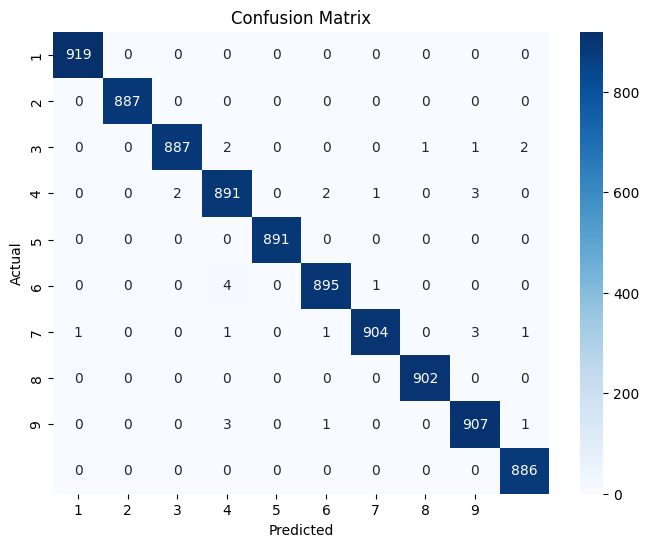

Model saved as xgboost_digit_classifier.model


c:\Users\VINY\miniconda3\envs\vision\lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [32]:
# Split Data (Train: 70%, Eval: 15%, Test: 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {len(X_train)}, Eval size: {len(X_eval)}, Test size: {len(X_test)}")

# Train XGBoost Classifier with GPU
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method="hist",  # Faster histogram-based method
    device="cuda"  # Use GPU
)

model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=True)

# Predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
model.save_model("xgboost_digit_classifier.model")
print("Model saved as xgboost_digit_classifier.model")

In [28]:
from time import time
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
import xgboost as xgb
import matplotlib.pyplot as plt
from loguru import logger

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # ResNet18 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the pretrained ResNet18 model (as feature extractor)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final classification layer
resnet.to(device)
resnet.eval()

# Load the trained XGBoost classifier
model = xgb.XGBClassifier()
model.load_model("xgboost_digit_classifier.model")

def classify_digit(image):
    # Step 2: Apply transformations
    transformed_image = transform(image)
    transformed_image = transformed_image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

    # Step 3: Extract features using ResNet18
    with torch.no_grad():
        features = resnet(transformed_image)  # Output shape: [batch, 512, 1, 1]
        features = features.view(features.size(0), -1).cpu().numpy()  # Flatten and move to CPU

    # Step 4: Classify the extracted features using the XGBoost model
    probs = model.predict_proba(features)  # Get class probabilities
    predicted_class = np.argmax(probs, axis=1)  # Get the class with highest probability
    confidence = np.max(probs, axis=1) 
    return predicted_class, confidence, probs

prediction: [0] confidence: [0.9999652]


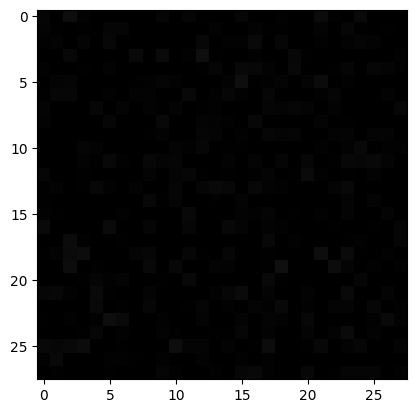

In [62]:
from create_dataset import generate_digit_image, generate_empty_image
import random
import numpy as np
import matplotlib.pyplot as plt
if random.randint(1,10)==1:
    image = generate_empty_image()
else:
    image = generate_digit_image(random.randint(1,9))
image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
plt.imshow(image,cmap='gray')


prediction, confidence, _ = classify_digit(image)
print(f'prediction: {prediction} confidence: {confidence}')